In [1]:
%matplotlib widget
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

# matplotlib.pyplot will be used in these examples to generate the plots visualizing the data
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider
import numpy as np
from scipy import signal

# import datashader as ds
# import datashader.transfer_functions as tf
import pandas as pd
import numpy as np
import pynapple as nap


import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

na = np.array
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

def detect_extreme_events(signal, window_size=5000, threshold_std=5, min_separation=2000, min_event_length=500, dt=0.0004):
    """
    Detects events in the signal that are below mean - (threshold_std * std_dev) or above mean + (threshold_std * std_dev),
    extracts windows around the peaks using the Hilbert transform, ensuring minimum separation between events and a minimum event length.

    Parameters:
    signal (np.array): 1D array of signal data.
    window_size (int): Number of samples to include in each window.
    threshold_std (float): Threshold in terms of standard deviations.
    min_separation (int): Minimum number of points between consecutive events.
    min_event_length (int): Minimum length of an event to be considered valid.
    dt (float): Time step for converting indices to time intervals.
    
    Returns:
    list of np.array: Extracted event windows.
    list of list: Time intervals for detected events.
    """
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    lower_threshold = mean_val - (threshold_std * std_val)
    # upper_threshold = mean_val + (threshold_std * std_val)
    
    # Find indices where signal is below or above the threshold
    low_event_indices = np.where(signal < lower_threshold)[0]
    # high_event_indices = np.where(signal > upper_threshold)[0]
    # event_indices = np.sort(np.concatenate((low_event_indices)))#,
    event_indices = np.sort(low_event_indices)#,
    
    # Ensure events are at least min_separation apart
    filtered_indices = []
    last_idx = -min_separation
    for idx in event_indices:
        if idx - last_idx >= min_separation:
            filtered_indices.append(idx)
            last_idx = idx
    
    # Compute Hilbert transform and envelope
    analytic_signal = scipy.signal.hilbert(signal)
    envelope = np.abs(analytic_signal)
    
    # Extract windows around the peak of the envelope
    windows = []
    intervals = []
    for idx in filtered_indices:
        peak_idx = idx + np.argmax(envelope[idx:idx + window_size])
        start = max(0, peak_idx - window_size // 2)
        end = min(len(signal), peak_idx + window_size // 2)
        
        # Apply minimum event length constraint
        if (end - start) >= min_event_length:
            windows.append(signal[start:end])
            intervals.append([float(start) * dt, float(end) * dt])
    
    return windows, intervals



def load_data(file_name):
    fs=10000
    channel_raw_data = McsPy.McsData.RawData(file_name)    
    # get channel IDs
    channel_ids =list(channel_raw_data.recordings[0].analog_streams[0].channel_infos)
    channel_ids = np.hstack(channel_ids)
    channel_labels = [channel_raw_data.recordings[0].analog_streams[0].channel_infos[i].info['Label'] for i in channel_ids]
    analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
    analog_stream_0_data = analog_stream_0.channel_data
    adc_step = analog_stream_0.channel_infos[2].adc_step.magnitude 
    #get offsets
    offsets = [analog_stream_0.channel_infos[id_].get_field('ADZero') for id_ in channel_ids]
    
    y = na(analog_stream_0_data)
    # correct to Volts
    y = np.subtract(y,na(offsets).reshape(-1,1))*adc_step
    x =np.arange(0,len(y[0,:]))/fs

    return x,y


In [2]:
file_name

NameError: name 'file_name' is not defined

In [146]:
y = np.subtract(y,na(offsets).reshape(-1,1))*adc_step
x =np.arange(0,len(y[0,:]))/fs

In [136]:
%%time
fs=10000

file_name = '/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/Shaimma/Shaima_example/2025-01-17T22-30-24McsRecording.h5'
channel_raw_data = McsPy.McsData.RawData(file_name)    
# get channel IDs
channel_ids =list(channel_raw_data.recordings[0].analog_streams[0].channel_infos)
channel_ids = np.hstack(channel_ids)
channel_labels = [channel_raw_data.recordings[0].analog_streams[0].channel_infos[i].info['Label'] for i in channel_ids]
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
analog_stream_0_data = analog_stream_0.channel_data

#
adc_step = analog_stream_0.channel_infos[2].adc_step.magnitude 
#get offsets
offsets = [analog_stream_0.channel_infos[id_].get_field('ADZero') for id_ in channel_ids]

y = na(analog_stream_0_data)
# correct to Volts
y = np.subtract(y,na(offsets).reshape(-1,1))*adc_step
x =np.arange(0,len(y[0,:]))/fs

# import pynapple as nap
# preselect elecrodes where interesting things happen
# Filter LFPs

downsample_factor = 4
fs_new = fs // downsample_factor  # New sampling rate (2500 Hz)
data_to_store = []

for i in range(252):
    y_down = signal.decimate(y[i,:], downsample_factor, ftype="fir")
    tsd = nap.Tsd(t=x[::downsample_factor], d=y_down,columns = np.arange(0,y_down.shape[0]))
    # get only LFP ignore all spikes 
    data_band = nap.apply_bandpass_filter(tsd, cutoff=(.1, 200.0), fs=fs_new,mode='butter', order=6)
    extr_thr = np.sum(data_band < (np.mean(data_band)-np.std(data_band))*7)
    if extr_thr>0:
        event_windows,intervals = detect_extreme_events(data_band.d,dt=(1/fs_new))
        data_to_store.append([file_name,channel_labels[i],event_windows,intervals])
    # else:
        
    # extra_threhsold.append()
# results = pd.DataFrame(data_to_store)
results = pd.DataFrame(data_to_store,columns=['file_name','electrode','events','time_window'])

# results.to_csv(file_name.split('.')[0]+'.csv')
# break

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 6177000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">


KeyboardInterrupt: 

In [143]:
data_to_store = []
for i in range(252):
    y_down = signal.decimate(y[i,:], downsample_factor, ftype="fir")
    tsd = nap.Tsd(t=x[::downsample_factor], d=y_down,columns = np.arange(0,y_down.shape[0]))
    # get only LFP ignore all spikes 
    data_band = nap.apply_bandpass_filter(tsd, cutoff=(.1, 200.0), fs=fs_new,mode='butter', order=6)
    extr_thr = np.sum(data_band < (np.mean(data_band)-np.std(data_band))*7)
    if extr_thr>0:
        event_windows,intervals = detect_extreme_events(data_band.d,dt=(1/fs_new), window_size=4000, min_event_length=1000,
        threshold_std=10,
        min_separation=5000,)
        data_to_store.append([file_name,channel_labels[i],event_windows,intervals])
    # else:
        
    # extra_threhsold.append()
# results = pd.DataFrame(data_to_store)
results = pd.DataFrame(data_to_store,columns=['file_name','electrode','events','time_window'])

# results.to_csv(file_name.split('.')[0]+'.csv')
# break

In [89]:
labels = dict([[i,ii] for ii,i in enumerate(channel_labels)])


,file_name,electrode,events,time_window
0,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,H10,"[[-1.1406695179496618e-06, -1.9227126909449643...","[[85.25160000000001, 86.8516], [92.5732, 94.17..."
1,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,G13,"[[3.2726119465673987e-07, 8.459247981469848e-0...","[[29.845200000000002, 31.4452], [59.7692000000..."
2,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,G15,"[[-1.6719024477172327e-06, -1.606300234461344e...","[[369.03000000000003, 370.63], [451.8332000000..."
3,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,J10,"[[-1.3615974981974438e-06, -1.5451807939092487...","[[85.2616, 86.86160000000001], [96.09960000000..."
4,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,F14,"[[-3.775214357192606e-07, -3.01882534451424e-0...","[[59.7864, 61.3864], [81.5532, 83.1532], [144...."
...,...,...,...,...
73,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,A3,"[[-2.303925545520996e-06, -2.389540794387269e-...","[[369.03040000000004, 370.6304], [557.354, 558..."
74,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,C3,"[[9.632280839862153e-07, 7.711885343010604e-07...","[[557.3812, 558.9812000000001], [559.8292, 561..."
75,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,B1,"[[1.8904990387483704e-06, 2.4882712323199796e-...","[[557.4172, 559.0172], [559.6688, 561.2688], [..."
76,/Users/ovinogradov/Documents/Projects/SCN1A/ME...,C1,"[[-2.6078015769025532e-08, 1.628774455318375e-...","[[369.03040000000004, 370.6304], [461.3684, 46..."


/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


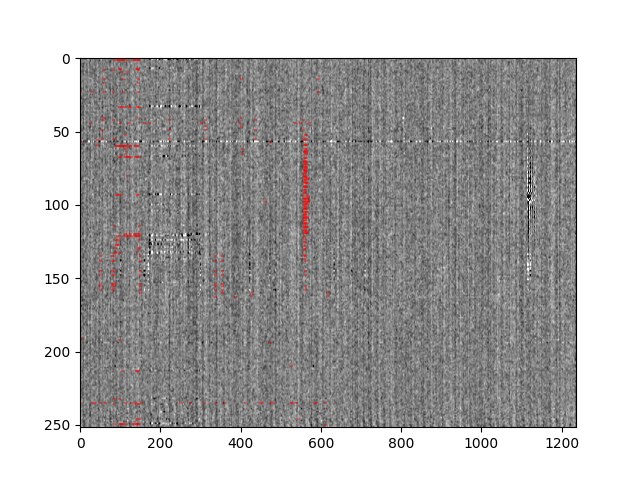

In [265]:
plt.figure()
plt.imshow(y[:,::10000]*scale_factor_for_uV,aspect= 'auto',cmap = 'grey',vmin=-10,vmax=10,interpolation='gaussian')
for r in results.iterrows():
    i = labels[r[1]['electrode']]    
    [plt.plot([k[0],k[1]],[i*1,i*1],'r',alpha=0.4) for k in r[1]['time_window']]

In [273]:
file_name

'/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/Shaimma/Shaima_example/2025-01-17T22-30-24McsRecording.h5'

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


([], [])

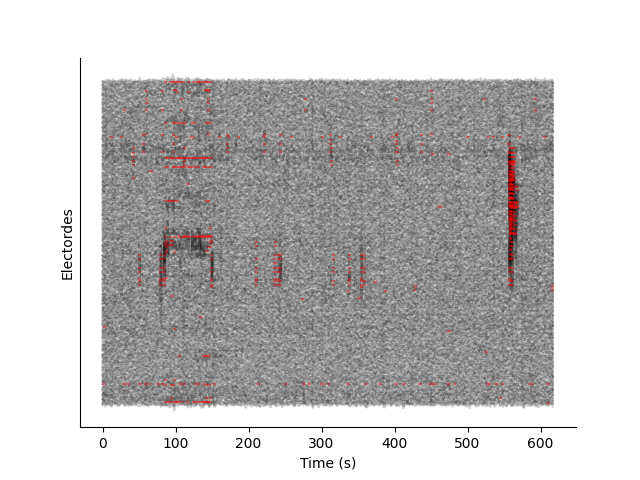

In [283]:
%matplotlib widget
import seaborn as sns

plt.figure()

[plt.plot(x[::10000],y[i,::10000]-i*0.000005,'k',alpha=0.2,rasterized= True) for i in range(252)];
for r in results.iterrows():
    i = labels[r[1]['electrode']]    
    [plt.plot([k[0],k[1]],[-i*0.000005,-i*0.000005],'r',alpha=0.4) for k in r[1]['time_window']]
plt.xlabel('Time (s)')
plt.ylabel('Electordes')
sns.despine()
plt.yticks([],[])
# plt.savefig('/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/figs/forShaimma.pdf')


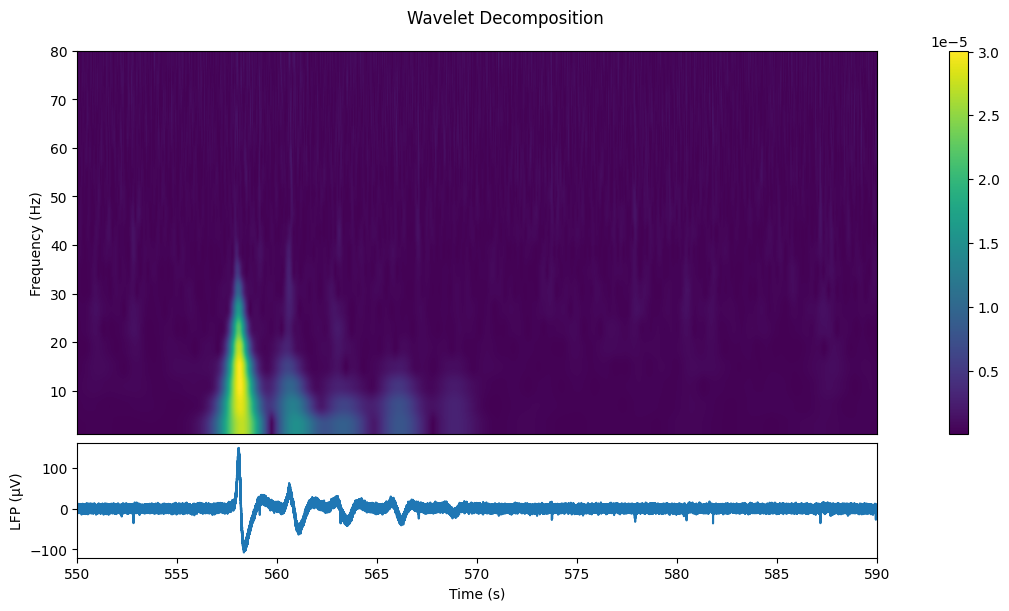

In [277]:
# Define wavelet decomposition plotting function
def plot_timefrequency(freqs, powers, ax=None,t=None):
    t1,t2 = t
    im = ax.imshow(np.abs(powers), aspect="auto",extent = [t1,t2,np.max(freqs),np.min(freqs)])
    ax.invert_yaxis()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.get_xaxis().set_visible(False)
    # ax.set(yticks=np.arange(len(freqs))[::2], yticklabels=np.rint(freqs[::2]))
    ax.grid(False)
    return im

t1,t2 = (550,590)
dat = nap.Tsd(t=x[(x>t1)*(x<t2)], d=y[80,(x>t1)*(x<t2)])
data_band = dat#nap.apply_bandpass_filter(dat, cutoff=(.1, 100.0), fs=fs,mode='butter', order=4)


freqs = np.geomspace(1, 80,20)


cwt_rem = nap.compute_wavelet_transform(data_band, fs=fs, freqs=freqs)

fig = plt.figure(constrained_layout=True, figsize=(10, 6))
fig.suptitle("Wavelet Decomposition")
gs = plt.GridSpec(2, 1, figure=fig, height_ratios=[1.0, 0.3])
ax0 = plt.subplot(gs[0, 0])
im = plot_timefrequency(freqs, np.transpose(cwt_rem[:, :].values), ax=ax0,t=(t1,t2))
ax0.set_xlim(t1,t2)
cbar = fig.colorbar(im, ax=ax0, orientation="vertical")
ax1 = plt.subplot(gs[1, 0])
ax1.plot(data_band*scale_factor_for_uV)
ax1.set_ylabel("LFP (µV)")
ax1.set_xlabel("Time (s)")
ax1.set_xlim(t1,t2)
plt.savefig('/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/figs/forShaimma/ex1.pdf')

# ax1.margins(0)

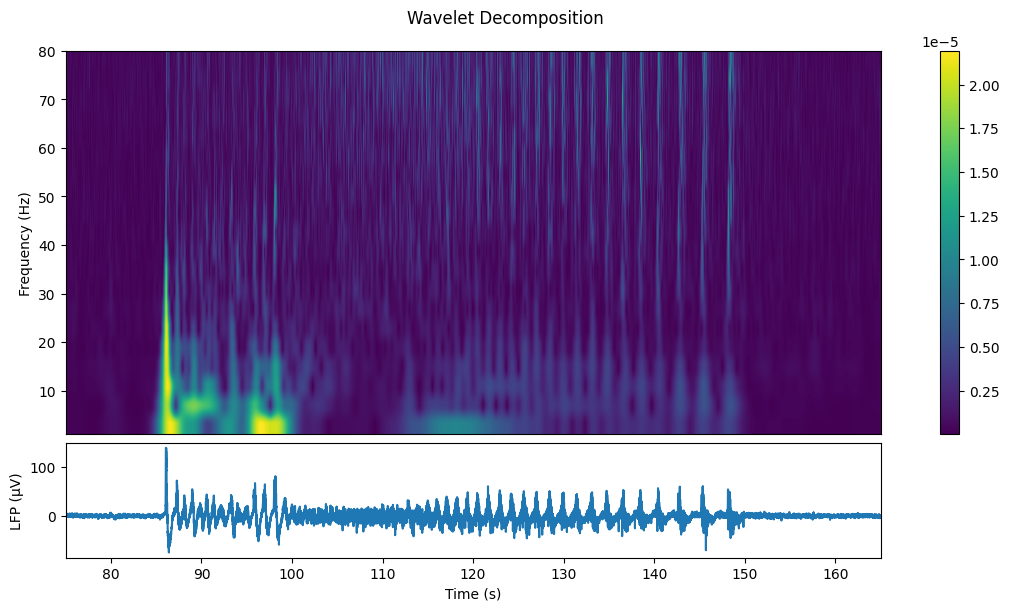

In [278]:
# Define wavelet decomposition plotting function
def plot_timefrequency(freqs, powers, ax=None,t=None):
    t1,t2 = t
    im = ax.imshow(np.abs(powers), aspect="auto",extent = [t1,t2,np.max(freqs),np.min(freqs)])
    ax.invert_yaxis()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.get_xaxis().set_visible(False)
    # ax.set(yticks=np.arange(len(freqs))[::2], yticklabels=np.rint(freqs[::2]))
    ax.grid(False)
    return im


t1,t2 = (75,165)
ids=121
dat = nap.Tsd(t=x[(x>t1)*(x<t2)], d=y[ids,(x>t1)*(x<t2)])
data_band = nap.apply_bandpass_filter(dat, cutoff=(.1, 100.0), fs=fs,mode='butter', order=4)


freqs = np.geomspace(1, 80,20)


cwt_rem = nap.compute_wavelet_transform(data_band, fs=fs, freqs=freqs)

fig = plt.figure(constrained_layout=True, figsize=(10, 6))
fig.suptitle("Wavelet Decomposition")
gs = plt.GridSpec(2, 1, figure=fig, height_ratios=[1.0, 0.3])
ax0 = plt.subplot(gs[0, 0])
im = plot_timefrequency(freqs, np.transpose(cwt_rem[:, :].values), ax=ax0,t=(t1,t2))
ax0.set_xlim(t1,t2)
cbar = fig.colorbar(im, ax=ax0, orientation="vertical")
ax1 = plt.subplot(gs[1, 0])
ax1.plot(data_band*scale_factor_for_uV)
ax1.set_ylabel("LFP (µV)")
ax1.set_xlabel("Time (s)")
ax1.set_xlim(t1,t2)
# ax1.margins(0)
plt.savefig('/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/figs/forShaimma/ex2.pdf')


In [ ]:
t1,t2 = 75,16
ids=121

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


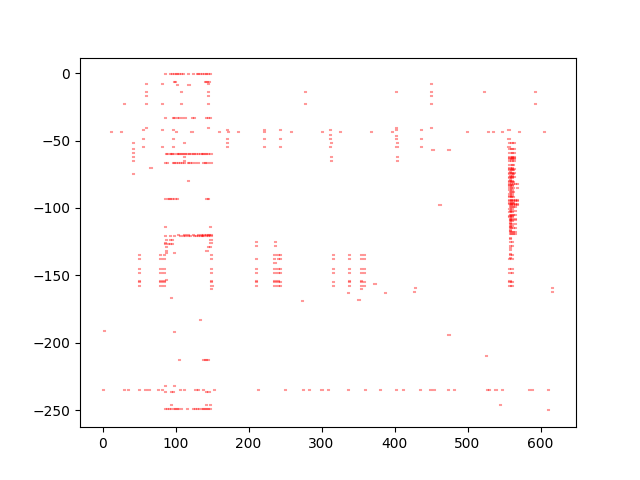

In [150]:
plt.figure()
for r in results.iterrows():
    i = labels[r[1]['electrode']]    
    [plt.plot([k[0],k[1]],[-i*1,-i*1],'r',alpha=0.4) for k in r[1]['time_window']]

In [224]:
channel_raw_data.recordings[0].analog_streams[0].get_channel_in_range?

Signature:
channel_raw_data.recordings[0].analog_streams[0].get_channel_in_range(
    channel_id,
    idx_start=0,
    idx_end=None,
)
Docstring:
Get the signal of the given channel over the course of time and in its measured range.

:param channel_id: ID of the channel
:param idx_start: index of the first sampled signal value that should be returned (0 <= idx_start < idx_end <= count samples). Default: 0
:param idx_end: index of the last sampled signal value that should be returned (0 <= idx_start < idx_end <= count samples). Default: None (= last index)
:return: Tuple (vector of the signal, unit of the values)
File:      ~/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/McsPy/McsData.py
Type:      method

In [228]:
signal = channel_raw_data.recordings[0].analog_streams[0].get_channel_in_range(100,0,10)

(array([-3.685320e-07,  2.886834e-06,  3.071100e-06, -6.142200e-08,
        -1.044174e-06,  1.167018e-06,  2.303325e-06,  6.295755e-06,
         7.769883e-06,  1.750527e-06,  4.913760e-07]),
 <Unit('volt')>)

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


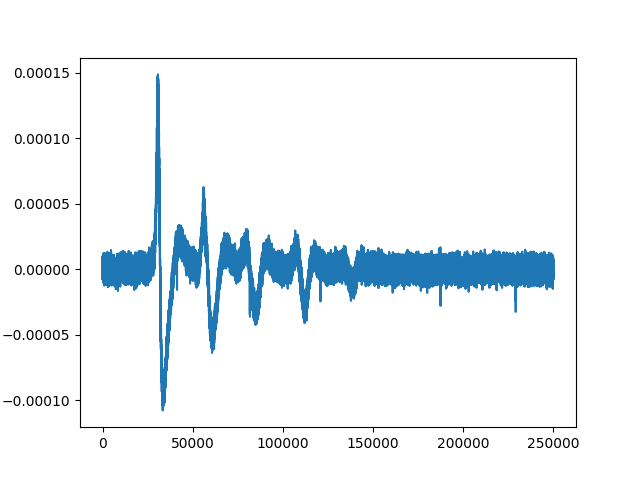

In [154]:
plt.figure()
plt.plot(y[80,(x>555)*(x<580)])

In [187]:
y

array([[-1.197729e-06, -4.913760e-07,  4.145985e-06, ..., -3.378210e-07,
         7.677750e-07,  7.984860e-07],
       [ 2.026926e-06,  3.378210e-06,  6.172911e-06, ..., -3.163233e-06,
        -8.015571e-06, -5.527980e-06],
       [-3.685320e-06, -2.026926e-06,  2.763990e-07, ...,  8.906190e-07,
         5.527980e-07,  2.733279e-06],
       ...,
       [-2.180481e-06,  5.835090e-07,  7.063530e-07, ..., -3.286077e-06,
        -3.224655e-06,  2.978967e-06],
       [-5.804379e-06, -3.931008e-06,  5.835090e-07, ..., -6.572154e-06,
        -2.241903e-06,  4.913760e-07],
       [ 1.412706e-06,  5.466558e-06, -1.689105e-06, ..., -1.904082e-06,
        -3.685320e-07,  1.535550e-07]])

In [230]:
from McsPy import ureg, Q_
# scale time to seconds:
# scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
# time_in_sec = time[0] * scale_factor_for_second

# get the signal
# signal = analog_stream.get_channel_in_range(channel_id, from_idx, to_idx)

# scale signal to µV:
scale_factor_for_uV = Q_(1,signal[1]).to(ureg.uV).magnitude
# signal_in_uV = signal[0] * scale_factor_for_uV

In [231]:
scale_factor_for_uV

1000000.0

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


(550.0, 590.0)

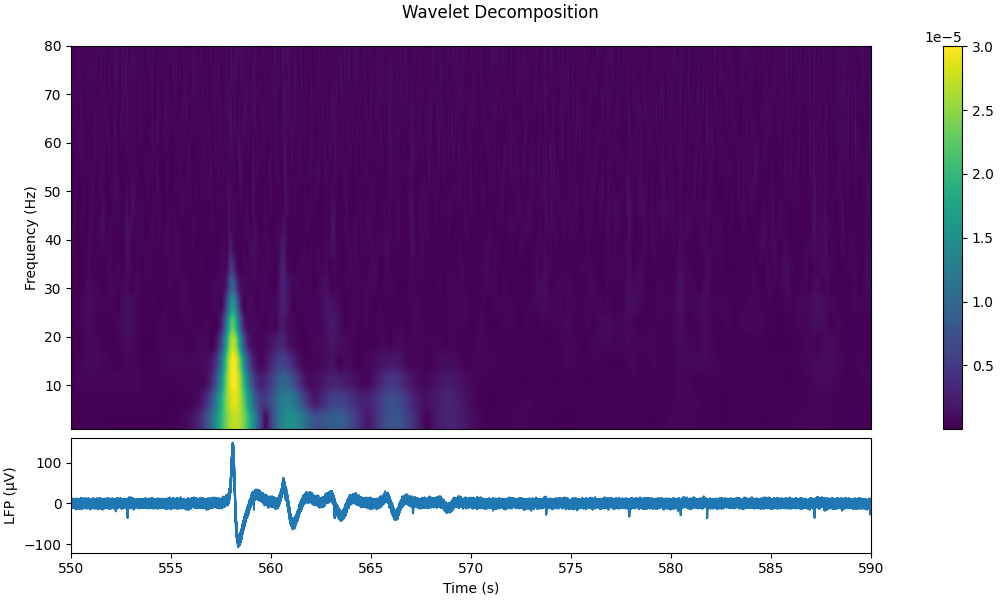

In [234]:
# Define wavelet decomposition plotting function
def plot_timefrequency(freqs, powers, ax=None,t=None):
    t1,t2 = t
    im = ax.imshow(np.abs(powers), aspect="auto",extent = [t1,t2,np.max(freqs),np.min(freqs)])
    ax.invert_yaxis()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.get_xaxis().set_visible(False)
    # ax.set(yticks=np.arange(len(freqs))[::2], yticklabels=np.rint(freqs[::2]))
    ax.grid(False)
    return im

t1,t2 = (550,590)
dat = nap.Tsd(t=x[(x>t1)*(x<t2)], d=y[80,(x>t1)*(x<t2)])
data_band = dat#nap.apply_bandpass_filter(dat, cutoff=(.1, 100.0), fs=fs,mode='butter', order=4)


freqs = np.geomspace(1, 80,20)


cwt_rem = nap.compute_wavelet_transform(data_band, fs=fs, freqs=freqs)

fig = plt.figure(constrained_layout=True, figsize=(10, 6))
fig.suptitle("Wavelet Decomposition")
gs = plt.GridSpec(2, 1, figure=fig, height_ratios=[1.0, 0.3])
ax0 = plt.subplot(gs[0, 0])
im = plot_timefrequency(freqs, np.transpose(cwt_rem[:, :].values), ax=ax0,t=(t1,t2))
ax0.set_xlim(t1,t2)
cbar = fig.colorbar(im, ax=ax0, orientation="vertical")
ax1 = plt.subplot(gs[1, 0])
ax1.plot(data_band*scale_factor_for_uV)
ax1.set_ylabel("LFP (µV)")
ax1.set_xlabel("Time (s)")
ax1.set_xlim(t1,t2)
# ax1.margins(0)

In [ ]:
80, x =[555, 570]



/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


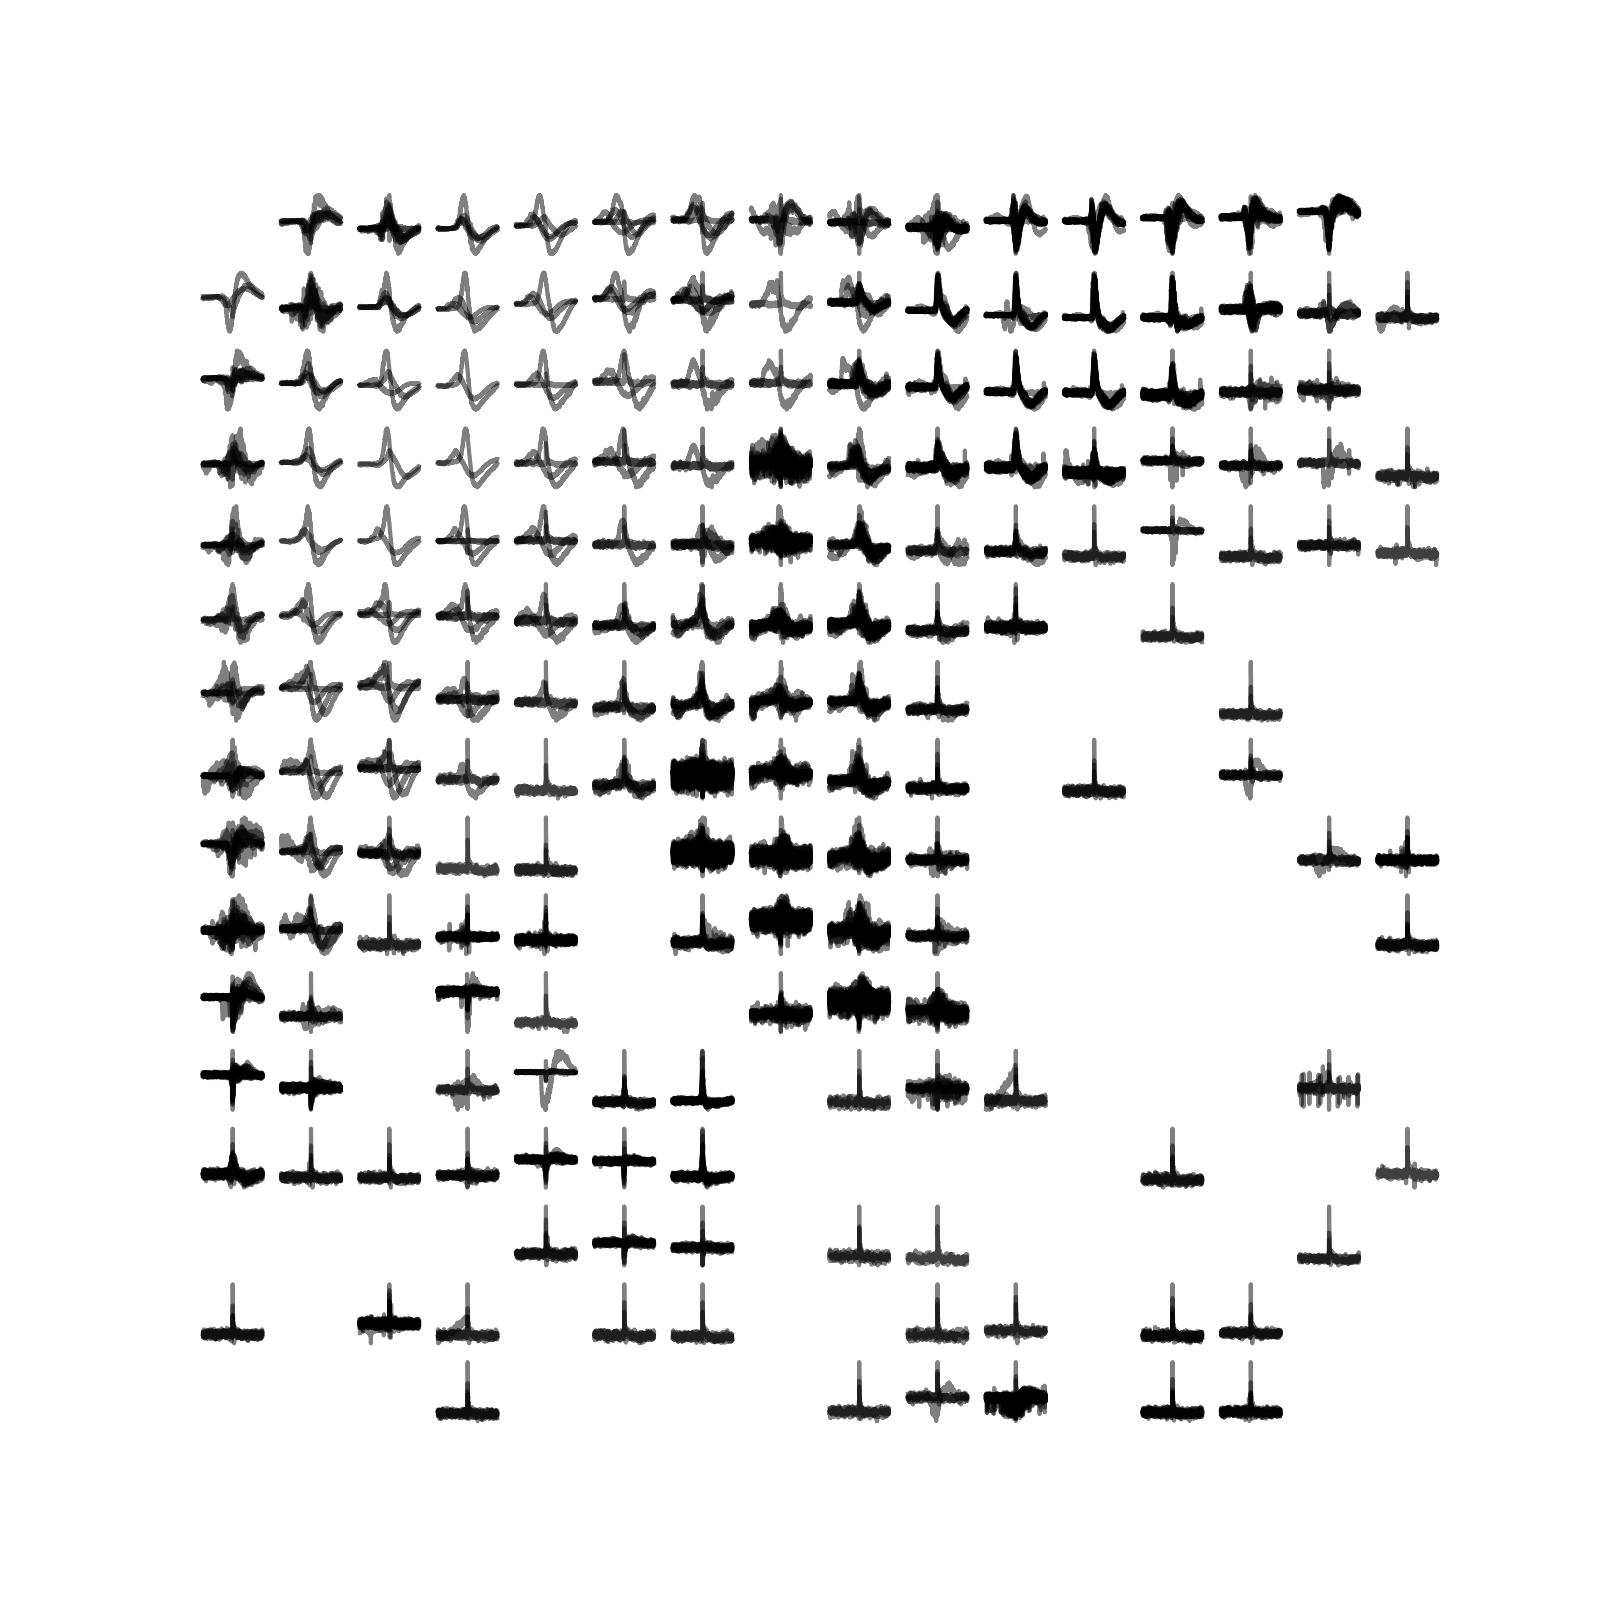

In [133]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure
def get_axes():
    fig, axs = plt.subplots(16, 16, figsize=(8, 8),dpi=200)
    letters = ['A','B','C','D','E','F','G','H','J','K','L','M','N','O','P','R']
    # Set the labels for each subplot
    labels = [
        [f"{letters[j]}{i + 1}" for j in range(16)] for i in range(16)
    ]

    # Plot circles with text in each subplot
    ax_dict = {}
    for i in range(16):
        for j in range(16):
            ax = axs[i, j]
            ax.axis('off')
#             circle = patches.Circle((0.5, 0.5), radius=0.4,facecolor=[1,1,1],edgecolor='skyblue')#, color='skyblue')
#             ax.add_patch(circle)
            ax_dict[labels[i][j]] =ax
    return fig, ax_dict

# fig,ax = get_axes()    

fig,ax = get_axes()
for index,r in results.iterrows():
    [ax[r['electrode']].plot(e,'k',alpha=0.5) for e in r['events']]

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


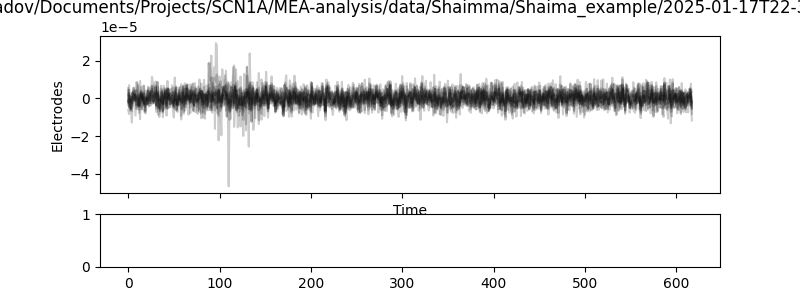

In [31]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.widgets import SpanSelector
from IPython.display import display
import numpy as np
import json

# Arrays to store the labeled timestamp windows
labeled_windows = []
highlighted_regions = []

# Sample file name (use your actual file name here)
### TODO: CHANGE HERE TO RECORD EVENTS IN A MEANINGFUL FOLDER
# Create a figure and axis
fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 3), sharex=True)
# Use your own data here
line = ax[0].plot(x[::10000],y[:10,::10000].T,'k',alpha=0.2)
# line, = ax[1].plot(bins[1:], sc, label='sc')

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Electrodes')
ax[0].set_title('Data%s' % file_name)

# Output widget for displaying labeled windows
output = widgets.Output()

# Function to delete a labeled window
def delete_labeled_window():
    index = select_event.index  # Get the selected event index
    if index >= 0:
        # Remove the event from the list
        labeled_windows.pop(index)
        update_label_list()

# Function to update the scrollable list of labels and plot highlighted regions
def update_label_list():
    # Remove existing highlights
    for region in highlighted_regions:
        region.remove()
    highlighted_regions.clear()

    # Create a new select widget options and highlight on the plot
    options = []
    for i, (xmin, xmax) in enumerate(labeled_windows):
        options.append(f"Event {i+1}: {xmin:.2f} - {xmax:.2f}")
        
        # Highlight the labeled region on both subplots
        region_top = ax[0].axvspan(xmin, xmax, color='yellow', alpha=0.3)
        # region_bottom = ax[].axvspan(xmin, xmax, color='yellow', alpha=0.3)
        
        # Store the highlighted regions to remove later if needed
        highlighted_regions.append(region_top)
        highlighted_regions.append(region_bottom)

    # Update the Select widget
    select_event.options = options
    
    # Redraw the plot to show the highlights
    plt.draw()

# Function to handle span selection (mouse drag)
def onselect(xmin, xmax):
    labeled_windows.append((xmin, xmax))
    update_label_list()
    with output:
        print(f"Labeled Window: {xmin} - {xmax}")

# Initialize the span selector without span_stays
span = SpanSelector(ax[1], onselect, 'horizontal', useblit=True, minspan=0.1)

# Show the plot
plt.show()

# Select widget for displaying events
select_event = widgets.Select(
    options=[],
    description='Events',
    layout=widgets.Layout(width='300px', height='200px')  # Scrollable select box
)

# FloatText widgets to edit the selected event's start and end times
start_text = widgets.FloatText(description='Start', layout=widgets.Layout(width='150px'))
end_text = widgets.FloatText(description='End', layout=widgets.Layout(width='150px'))

# Button to update the event in the list
update_button = widgets.Button(description='Update Event')

# Button to delete the selected event
delete_button = widgets.Button(description='Delete Event', button_style='danger')

# Function to update the "start" and "end" fields when an event is selected
def on_event_select(change):
    index = select_event.index  # Get the index of the selected event
    if index >= 0:
        start, end = labeled_windows[index]  # Get the start and end of the selected event
        start_text.value = start
        end_text.value = end

# Attach the callback to the Select widget
select_event.observe(on_event_select, names='value')

# Function to update the event list when the update button is clicked
def on_update_button_click(b):
    index = select_event.index
    if index >= 0:
        # Update the selected event's start and end times
        labeled_windows[index] = (start_text.value, end_text.value)
        # Update the Select widget options
        update_label_list()
        # Optionally print the updated list to output
        with output:
            output.clear_output()
            print(f"Updated Event {index+1}: Start = {start_text.value}, End = {end_text.value}")

# Attach the update function to the button
update_button.on_click(on_update_button_click)

# Attach the delete function to the delete button
delete_button.on_click(lambda x: delete_labeled_window())

# Button to display the labeled windows array
def display_labeled_windows():
    with output:
        output.clear_output()
        print("Labeled Windows Array:", labeled_windows)

display_button = widgets.Button(description="Show Labeled Windows")
display_button.on_click(lambda x: display_labeled_windows())

# Function to save the labeled windows as a JSON file
def save_labeled_windows():
    data = {"events": labeled_windows}
    filename = f"{file_name}.json"
    
    with open(filename, "w") as f:
        json.dump(data, f)
    
    with output:
        output.clear_output()
        print(f"Saved events to {filename}")

# Save button widget
save_button = widgets.Button(description="Save Events", button_style='success')
save_button.on_click(lambda x: save_labeled_windows())

# Display all widgets in a single layout once (no duplicates)
display(widgets.VBox([display_button, select_event, start_text, end_text, update_button, delete_button, save_button, output]))

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


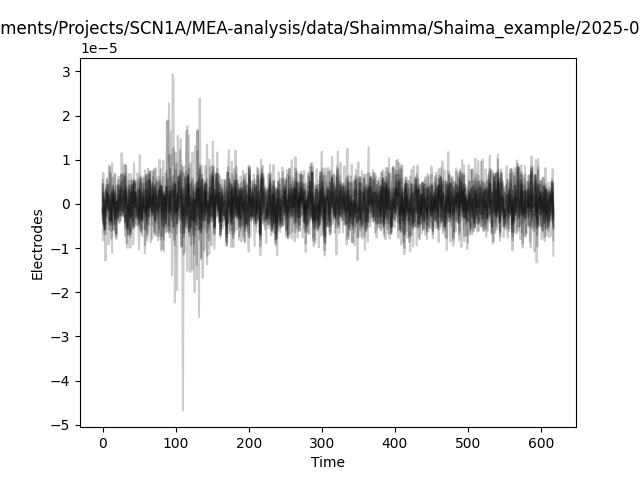

In [76]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.widgets import SpanSelector
from IPython.display import display
import numpy as np
import json

# Arrays to store the labeled timestamp windows
labeled_windows = []
highlighted_regions = []
selection_active = False

# Sample file name (use your actual file name here)
### TODO: CHANGE HERE TO RECORD EVENTS IN A MEANINGFUL FOLDER
# Create a figure and axis
fig, ax = plt.subplots(1,1)#,# gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 3), sharex=True)
# Use your own data here
line = ax.plot(x[::10000],y[:10,::10000].T,'k',alpha=0.2)

ax.set_xlabel('Time')
ax.set_ylabel('Electrodes')
ax.set_title('Data%s' % file_name)# Output widget for displaying labeled windows
output = widgets.Output()

# Function to delete a labeled window
def delete_labeled_window():
    index = select_event.index  # Get the selected event index
    if index >= 0:
        labeled_windows.pop(index)
        update_label_list()

# Function to update the scrollable list of labels and plot highlighted regions
def update_label_list():
    for region in highlighted_regions:
        region.remove()
    highlighted_regions.clear()

    options = []
    for i, (xmin, xmax, label) in enumerate(labeled_windows):
        options.append(f"Event {i+1}: {xmin:.2f} - {xmax:.2f} ({label})")
        region_top = ax[0].axvspan(xmin, xmax, color='yellow', alpha=0.3)
        highlighted_regions.append(region_top)
    
    select_event.options = options
    plt.draw()

# Function to handle span selection (mouse drag)
def onselect(xmin, xmax):
    global selection_active
    if selection_active:
        label = label_text.value
        labeled_windows.append((xmin, xmax, label))
        update_label_list()
        with output:
            output.clear_output()
            print(f"Labeled Window: {xmin} - {xmax}, Label: {label}")

# Toggle selection mode
def toggle_selection(b):
    global selection_active
    selection_active = not selection_active
    if selection_active:
        add_event_button.description = "Stop Adding Events"
    else:
        add_event_button.description = "Add Event"

# Initialize the span selector
span = SpanSelector(ax, onselect, 'horizontal', useblit=True, minspan=0.1)
plt.show()


# Select widget for displaying events
select_event = widgets.Select(options=[], description='Events', layout=widgets.Layout(width='300px', height='200px'))

start_text = widgets.FloatText(description='Start', layout=widgets.Layout(width='150px'))
end_text = widgets.FloatText(description='End', layout=widgets.Layout(width='150px'))
label_text = widgets.Text(description='Label', layout=widgets.Layout(width='150px'))

update_button = widgets.Button(description='Update Event')
delete_button = widgets.Button(description='Delete Event', button_style='danger')
add_event_button = widgets.Button(description='Add Event')
add_event_button.on_click(toggle_selection)

def on_event_select(change):
    index = select_event.index
    if index >= 0:
        start, end, label = labeled_windows[index]
        start_text.value = start
        end_text.value = end
        label_text.value = label

select_event.observe(on_event_select, names='value')

def on_update_button_click(b):
    index = select_event.index
    if index >= 0:
        labeled_windows[index] = (start_text.value, end_text.value, label_text.value)
        update_label_list()
        with output:
            output.clear_output()
            print(f"Updated Event {index+1}: Start = {start_text.value}, End = {end_text.value}, Label = {label_text.value}")

update_button.on_click(on_update_button_click)
delete_button.on_click(lambda x: delete_labeled_window())

def display_labeled_windows():
    with output:
        output.clear_output()
        print("Labeled Windows Array:", labeled_windows)

display_button = widgets.Button(description="Show Labeled Windows")
display_button.on_click(lambda x: display_labeled_windows())

def save_labeled_windows():
    data = {"events": labeled_windows}
    filename = f"{file_name}.json"
    
    with open(filename, "w") as f:
        json.dump(data, f)
    
    with output:
        output.clear_output()
        print(f"Saved events to {filename}")

save_button = widgets.Button(description="Save Events", button_style='success')
save_button.on_click(lambda x: save_labeled_windows())

display(widgets.VBox([add_event_button, display_button, select_event, start_text, end_text, label_text, update_button, delete_button, save_button, output]))
